In [1]:
%matplotlib inline
%matplotlib notebook
from ipynb.fs.defs.utilities import *
from colorspacious import cspace_converter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Computation of the Navion workspace for gastroscopy with magnetic transnasal endoscope

This notebook compute the workspace of the Navion for application of the TNE (Transnasal Endoscope) for gastroscopies.

In [2]:
# Customized color bar 1 (2 colors)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 177/256, N)
vals[:, 1] = np.linspace(130/256, 78/256, N)
vals[:, 2] = np.linspace(180/256, 132/256, N)
newcmp = ListedColormap(vals)

# Customized color bar 2 (3 colors)
 
vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 
vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)
cmp_blue_3col_inv = ListedColormap(cmp_blue_3col.colors[::-1])

cmp_blue_3col

# Customized color bar 3 (4 colors)

vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))
vals_seg3 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [227, 158, 33]
col3 = [255, 236, 203]
col4 = [138, 115, 86]
 
vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals_seg3[:, 0] = np.linspace(col3[0]/256, col4[0]/256, N)
vals_seg3[:, 1] = np.linspace(col3[1]/256, col4[1]/256, N)
vals_seg3[:, 2] = np.linspace(col3[2]/256, col4[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2,vals_seg3))

cmp_blue_4col = ListedColormap(vals,name='cmp_blue_4col')
cmp_blue_4col_inv = ListedColormap(cmp_blue_4col.colors[::-1],name='cmp_blue_4col_inv')


# Customized

col_l = [255, 255, 255]
col_d = [200, 200, 200]

vals_seg1[:, 0] = np.linspace(col_l[0]/256, col_d[0]/256, N)
vals_seg1[:, 1] = np.linspace(col_l[1]/256, col_d[1]/256, N)
vals_seg1[:, 2] = np.linspace(col_l[2]/256, col_d[2]/256, N)

vals = vals_seg1

n = 10
for i in range(n):
    vals = np.concatenate((vals,vals_seg1))

mask1 =  np.linspace(1, col1[0]/256, (n+1)*N)
mask2 =  np.linspace(1, col1[1]/256, (n+1)*N)
mask3 =  np.linspace(1, col1[2]/256, (n+1)*N)

vals[:, 0] = np.multiply(vals[:, 0],mask1)
vals[:, 1] = np.multiply(vals[:, 1],mask2)
vals[:, 2] = np.multiply(vals[:, 2],mask3)

cmp_alter = ListedColormap(vals)


# Customized

col_l = [200, 200, 200]
col_d = [col1[0], col1[1], col1[2]]

vals_seg1[:, 0] = np.linspace(col_l[0]/256, col_d[0]/256, N)
vals_seg1[:, 1] = np.linspace(col_l[1]/256, col_d[1]/256, N)
vals_seg1[:, 2] = np.linspace(col_l[2]/256, col_d[2]/256, N)

vals = vals_seg1

n = 1
for i in range(n):
    vals = np.concatenate((vals,vals_seg1))

mask1 =  np.linspace(1, col1[0]/256, (n+1)*N)
mask2 =  np.linspace(1, col1[1]/256, (n+1)*N)
mask3 =  np.linspace(1, col1[2]/256, (n+1)*N)

#vals[:, 0] = np.multiply(vals[:, 0],mask1)
#vals[:, 1] = np.multiply(vals[:, 1],mask2)
#vals[:, 2] = np.multiply(vals[:, 2],mask3)

cmp_alter2 = ListedColormap(vals)



In [3]:
# Load system calibration
cal_path_navion = os.path.join('models/Navion_2_Calibration_24-02-2020.yaml')

model_navion = ForwardModelMPEM()
model_navion.setCalibrationFile(cal_path_navion)

# Single plane

In [4]:
def ComputeMaxFieldInPos(model_mns,position,Imin,Imax):
    
    J = model_mns.getFieldActuationMatrix(position)

    #Check feasibility at each grid point            
    N, d = HyperPlaneShiftingMethod(J,Imin,Imax)

    bmax = np.min(d)

    return bmax

def ComputeMaxField(Nx,Ny,Nz,pmin,pmax,Imin,Imax,model_mns,threshold_mT=-1):

    p_ws = np.empty((0,3))
    max_field_mT = np.array([])

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True) 

    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                bmax = ComputeMaxFieldInPos(model_mns,position,Imin,Imax)
                
                if bmax > threshold_mT/1000:
                    p_ws = np.append(p_ws, [position], axis=0)                
                    max_field_mT = np.append(max_field_mT, [bmax*1000], axis=0)
                
    return p_ws, max_field_mT

# Volume

In [10]:
def ComputeMaxFieldPlane(Nx,Ny,pmin,pmax,offset,Imin,Imax,model_mns,zdir="z"):

    p_ws = np.empty((0,3))
    max_field_mT = np.array([])

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)

    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
                            
                x = posx_v[i]
                y = posy_v[j]

                if zdir == "z":
                    idx = 0
                    idy = 1
                    position = np.array([x,y,offset])
                elif zdir == "y":
                    idx = 2
                    idy = 0
                    position = np.array([y,offset,x])
                elif zdir == "x":
                    idx = 1
                    idy = 2
                    position = np.array([offset,x,y])
                
                bmax = ComputeMaxFieldInPos(model_mns,position,Imin,Imax)
                
                p_ws = np.append(p_ws, [position], axis=0)                
                max_field_mT = np.append(max_field_mT, [bmax*1000], axis=0)
    
    
    px_ = np.linspace(pmin[0], pmax[0], 70, endpoint=True)
    py_ = np.linspace(pmin[1], pmax[1], 70, endpoint=True)
    px, py = np.meshgrid(px_,py_)
    field = griddata((p_ws[:,idx], p_ws[:,idy]), max_field_mT/1000, (px_[None,:], py_[:,None]), method='linear')
    
    return px, py, field

In [27]:
#Volume
Nx = 50
Ny = 50

#Build initial box
pmin = np.array([-0.25,-0.25])
pmax = np.array([0.25,0.15])
Nxy = 40
offsetz = np.linspace(-0.20, 0.25, Nxy, endpoint=True)
zdir = 'z'

max_field_xy = []

for i in range(Nxy):
    px_xy, py_xy, max_field = ComputeMaxFieldPlane(Nx,Ny,pmin,pmax,offsetz[i],-45,45,model_navion,zdir=zdir)
    max_field_xy.append(max_field)

In [28]:
#Build initial box
pmin = np.array([-0.25,-0.25])
pmax = np.array([0.25,0.25])
Nxz = 4
offsety = np.linspace(-0.10, 0.15, Nxz, endpoint=True)
ydir = 'y'

max_field_xz = []

for i in range(Nxz):
    px_xz, py_xz, max_field = ComputeMaxFieldPlane(Nx,Ny,pmin,pmax,offsety[i],-45,45,model_navion,zdir=ydir)
    max_field_xz.append(max_field)

In [29]:
# Plot 3D coils
def PlotCoils3D_coord(length,radius,center,direction,ax,DoRaster=False):
    # length: length of the coils representation
    # radius: radius of the coils representation
    # ax: axis of the figure to represent the coils
    # DoRaster: rasterize the representation [True] or not [False]
    
    x_center = center[0]
    y_center = center[1]
    z_center = center[2]

    v_dir = np.array([direction[0], direction[1], direction[2]]) #dir

    #axis and radius
    p0 = np.array([x_center, y_center, z_center]) - length/2*v_dir #point at one end
    p1 = np.array([x_center, y_center, z_center]) + length/2*v_dir #point at other end

    #vector in direction of axis
    v = p1 - p0

    #find magnitude of vector
    mag = np.linalg.norm(v)

    #unit vector in direction of axis
    v = v / mag

    #make some vector perpendicular to v
    not_v_mat = np.array([[-v[1],v[0],0.],[-v[2],0.,v[0]],[0.,v[2],-v[1]]])
    norm_vec = np.linalg.norm(not_v_mat, axis=1)
    not_v = not_v_mat[np.argmax(norm_vec),:]

    #make vector perpendicular to v
    n1 = np.cross(v, not_v)
    #normalize n1
    n1 /= np.linalg.norm(n1)

    #make unit vector perpendicular to v and n1
    n2 = np.cross(v, n1)

    #surface ranges over t from 0 to length of axis and 0 to 2*pi
    t = np.linspace(0, mag, 2)
    theta = np.linspace(0, 2 * np.pi, 360) #use 360 for good sampling
    rsample = np.linspace(0, radius, 2)

    #use meshgrid to make 2d arrays
    t, theta2 = np.meshgrid(t, theta)

    rsample,theta = np.meshgrid(rsample, theta)

    #generate coordinates for surface
    # "Tube"
    X, Y, Z = [p0[i] + v[i] * t + radius * np.sin(theta2) * n1[i] + radius * np.cos(theta2) * n2[i] for i in [0, 1, 2]]
    # "Bottom"
    X2, Y2, Z2 = [p0[i] + rsample[i] * np.sin(theta) * n1[i] + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
    # "Top"
    X3, Y3, Z3 = [p0[i] + v[i]*mag + rsample[i] * np.sin(theta) * n1[i] + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]

    
     #rstride=1, cstride=1, linewidth=0, 
        
    #e39e21ff
        
    ax.plot_surface(X, Y, Z, color='peru', rstride=1, cstride=1, linewidth=0, antialiased=False, alpha=1.0, rasterized=DoRaster)
    ax.plot_surface(X2, Y2, Z2, color="peru",rstride=1, cstride=1, linewidth=0,  alpha=1.0, rasterized=DoRaster)
    ax.plot_surface(X3, Y3, Z3, color="peru",rstride=1, cstride=1, linewidth=0,  alpha=1.0, rasterized=DoRaster)

<IPython.core.display.Javascript object>


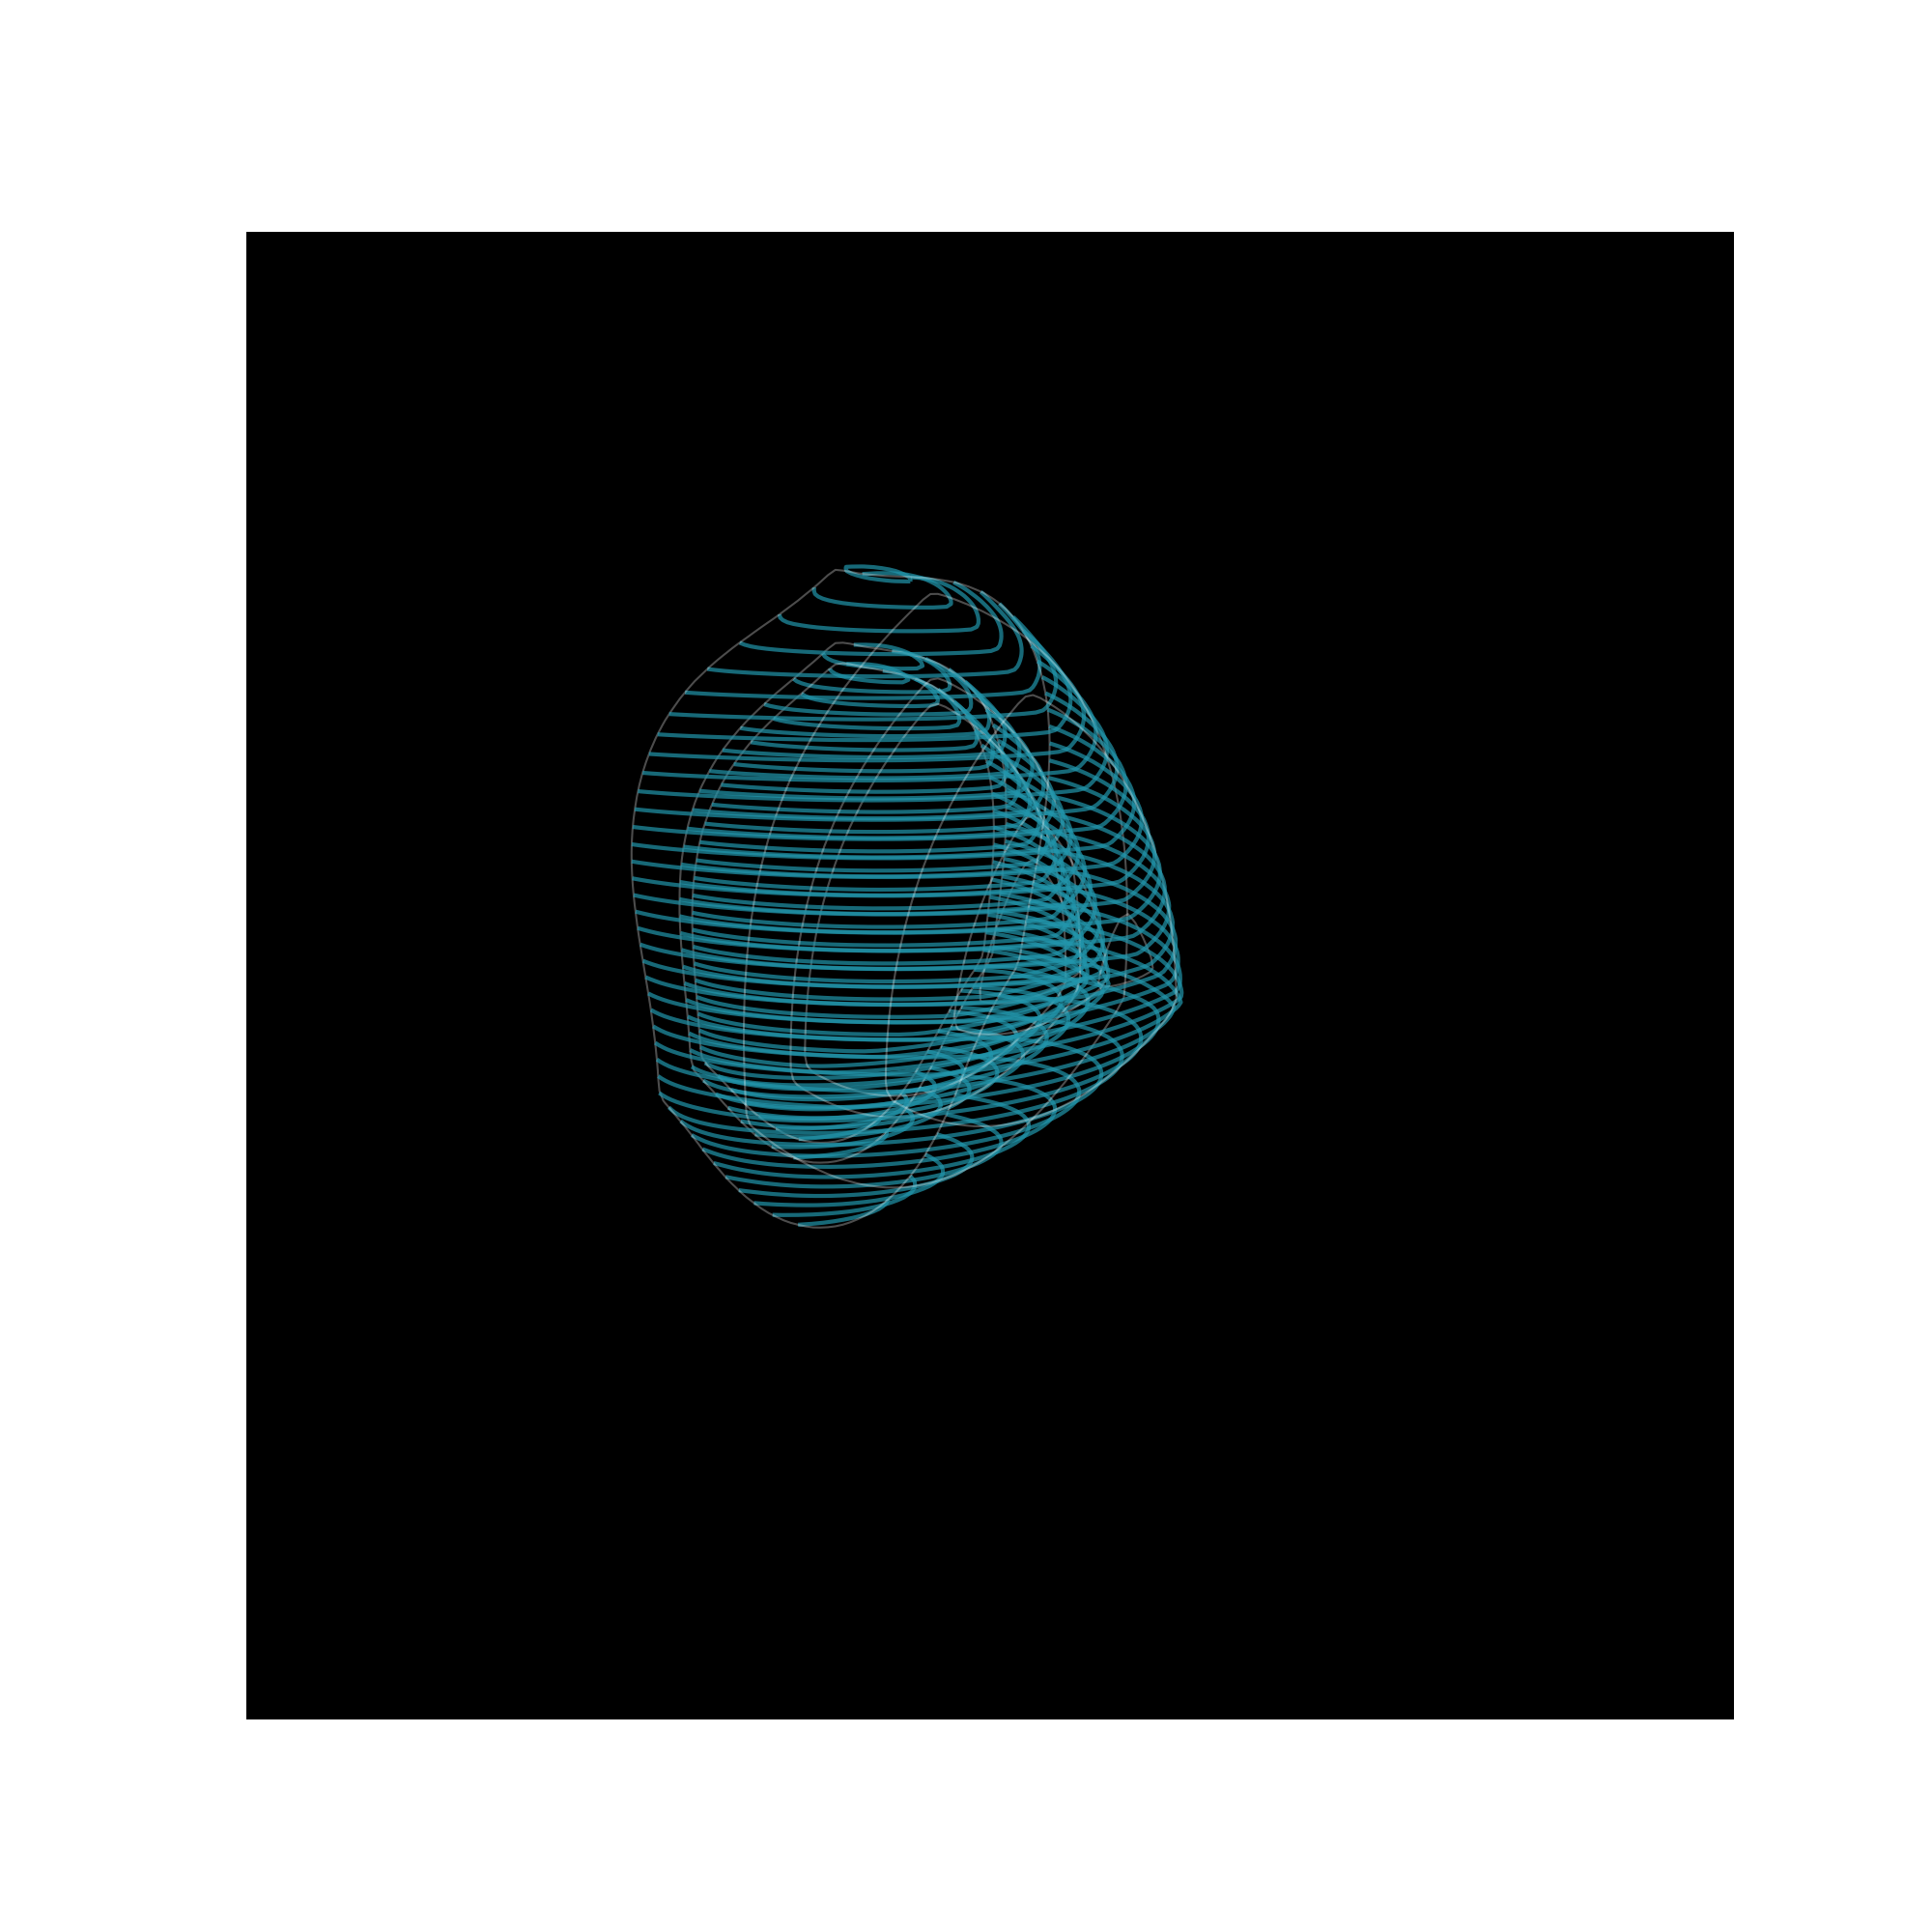

<ipython-input-37-747d682f2dfe>:25: UserWarning: No contour levels were found within the data range.
  ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 15, 17], zdir=zdir, offset=offsetz[i]*100, alpha=0.7, colors='#2296ac',linewidths=3, vmin=0, vmax=65)


In [37]:
cmap = cmp_alter2

fig = plt.figure(figsize=(20, 20))

plt.style.use('dark_background')
             
ax = plt.axes(projection='3d',proj_type = 'ortho')

ax.view_init(elev= 17, azim = -151)
#ax.view_init(elev= 0, azim = 180)

alpha_min = 0.3
alpha_max = 1.


dcoil = 10
R = 15

# Draw a circle on the x=0 'wall'
coil1 = Circle((0, R), dcoil,facecolor='white',edgecolor='k')
coil2 = Circle((0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')
coil3 = Circle((-0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')

for i in range(Nxy):
    ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 15, 17], zdir=zdir, offset=offsetz[i]*100, alpha=0.7, colors='#2296ac',linewidths=3, vmin=0, vmax=65)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [20], zdir=zdir, offset=offsetz[i]*100, alpha=0.5, cmap=cmap,linewidths=3, vmin=0, vmax=65)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [30], zdir=zdir, offset=offsetz[i]*100, alpha=0.7, cmap=cmap,linewidths=3, vmin=0, vmax=65)
for i in range(Nxz):
    ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10, 15, 17], zdir=ydir, offset=offsety[i]*100, alpha=0.3, colors='white',linestyles='solid')
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10,20,30], zdir=ydir, offset=offsety[i]*100, alpha=0.3, colors='white',linestyles='solid')

#ax.add_patch(coil1)
#art3d.pathpatch_2d_to_3d(coil1, z=20, zdir="y")
#ax.add_patch(coil2)
#art3d.pathpatch_2d_to_3d(coil2, z=20, zdir="y")
#ax.add_patch(coil3)
#art3d.pathpatch_2d_to_3d(coil3, z=20, zdir="y")

coil_length = 20
offset_y = 20

center1 = [0,offset_y+coil_length/2,R]
center2 = [0.87*R,offset_y+coil_length/2,-0.5*R]
center3 = [-0.87*R,offset_y+coil_length/2,-0.5*R]


direction = [0,1,0]
PlotCoils3D_coord(coil_length,dcoil,center1,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center2,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center3,direction,ax,True)
   
#Arg for linestyle: linestyles{None, 'solid', 'dashed', 'dashdot', 'dotted'}

#Ref points
#ax.scatter(0,20,0)
#ax.scatter(0,20,-10)

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim(-30,30)
ax.set_ylim(-20,20)
ax.set_zlim(-30,30)
ax.set_aspect('equal')
#ax.set_title('Maximum field magnitude [mT] for 50 A')

#ax.set_facecolor("grey")
plt.grid(False)
plt.axis('off')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))
plt.show()

<IPython.core.display.Javascript object>


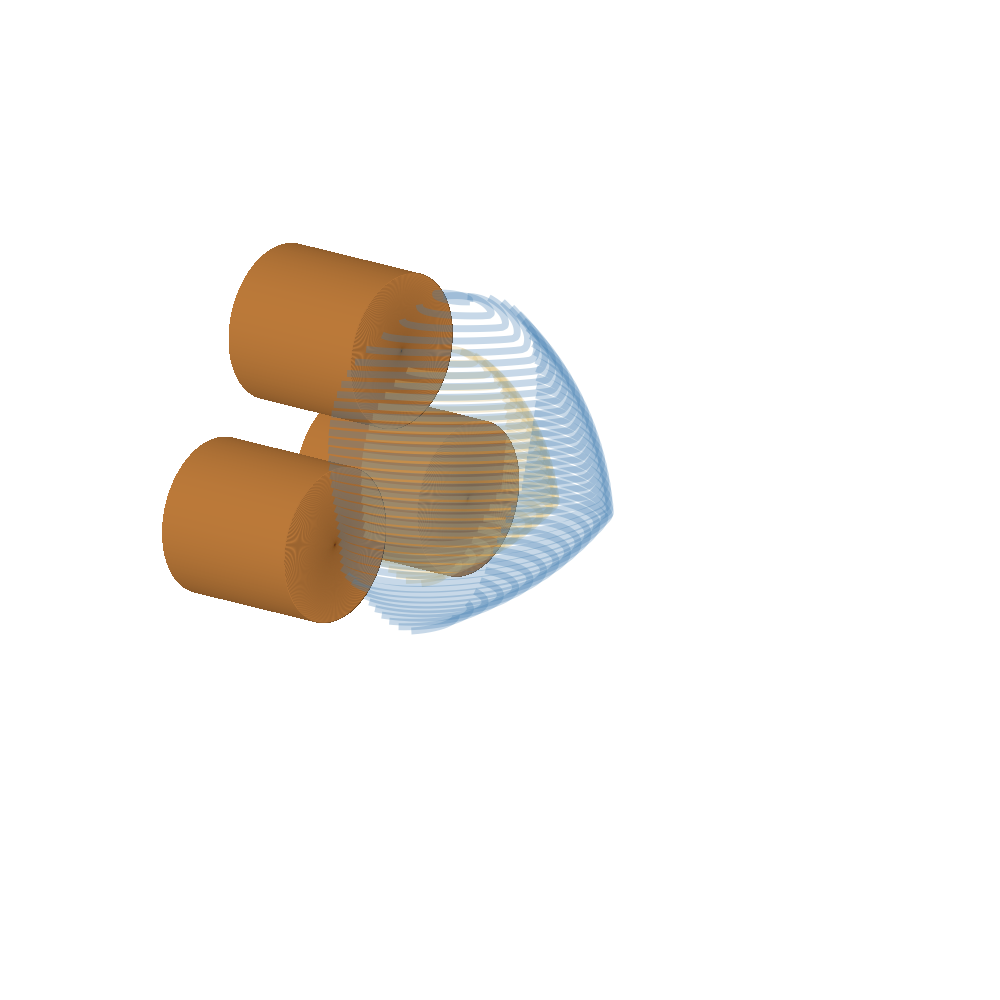

<ipython-input-54-2025af92f804>:25: UserWarning: No contour levels were found within the data range.
  ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 18], zdir=zdir, offset=offsetz[i]*100, alpha=0.3, cmap=cmap,linewidths=5, vmin=10, vmax=20)


In [54]:
cmap = cmp_blue_3col

fig = plt.figure(figsize=(10, 10))

plt.style.use('default')
             
ax = plt.axes(projection='3d',proj_type = 'ortho')

ax.view_init(elev= 17, azim = -140)
#ax.view_init(elev= 0, azim = 180)

alpha_min = 0.3
alpha_max = 1.


dcoil = 10
R = 15

# Draw a circle on the x=0 'wall'
coil1 = Circle((0, R), dcoil,facecolor='white',edgecolor='k')
coil2 = Circle((0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')
coil3 = Circle((-0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')

for i in range(Nxy):
    ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 18], zdir=zdir, offset=offsetz[i]*100, alpha=0.3, cmap=cmap,linewidths=5, vmin=10, vmax=20)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [20], zdir=zdir, offset=offsetz[i]*100, alpha=0.5, cmap=cmap,linewidths=3, vmin=0, vmax=65)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [30], zdir=zdir, offset=offsetz[i]*100, alpha=0.7, cmap=cmap,linewidths=3, vmin=0, vmax=65)
#for i in range(Nxz):
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10, 18], zdir=ydir, offset=offsety[i]*100, alpha=0.5, colors='black', linewidths=3, linestyles='solid')
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10,20,30], zdir=ydir, offset=offsety[i]*100, alpha=0.3, colors='white',linestyles='solid')

#ax.add_patch(coil1)
#art3d.pathpatch_2d_to_3d(coil1, z=20, zdir="y")
#ax.add_patch(coil2)
#art3d.pathpatch_2d_to_3d(coil2, z=20, zdir="y")
#ax.add_patch(coil3)
#art3d.pathpatch_2d_to_3d(coil3, z=20, zdir="y")

coil_length = 20
offset_y = 20

center1 = [0,offset_y+coil_length/2,R]
center2 = [0.87*R,offset_y+coil_length/2,-0.5*R]
center3 = [-0.87*R,offset_y+coil_length/2,-0.5*R]


direction = [0,1,0]
PlotCoils3D_coord(coil_length,dcoil,center1,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center2,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center3,direction,ax,True)
   
#Arg for linestyle: linestyles{None, 'solid', 'dashed', 'dashdot', 'dotted'}

#Ref points
#ax.scatter(0,20,0)
#ax.scatter(0,20,-10)

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim(-30,30)
ax.set_ylim(-20,20)
ax.set_zlim(-30,30)
ax.set_aspect('equal')
#ax.set_title('Maximum field magnitude [mT] for 50 A')

#ax.set_facecolor("grey")
plt.grid(False)
plt.axis('off')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))
plt.show()

<IPython.core.display.Javascript object>


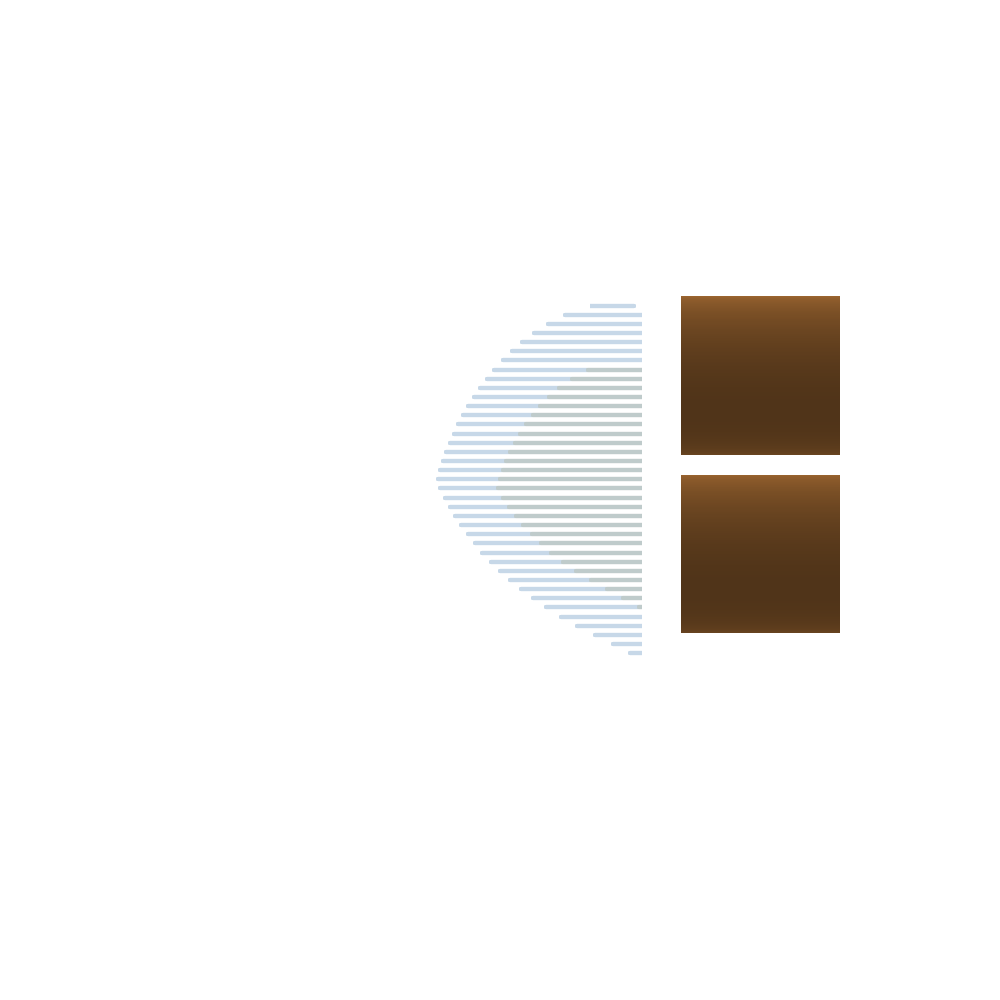

<ipython-input-58-b5df7ee18759>:25: UserWarning: No contour levels were found within the data range.
  ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 18], zdir=zdir, offset=offsetz[i]*100, alpha=0.3, cmap=cmap, linewidths=3, vmin=10, vmax=20)


In [58]:
cmap = cmp_blue_3col

fig = plt.figure(figsize=(10, 10))

plt.style.use('default')
             
ax = plt.axes(projection='3d',proj_type = 'ortho')

ax.view_init(elev= 0, azim = 0)
#ax.view_init(elev= 0, azim = 180)

alpha_min = 0.3
alpha_max = 1.


dcoil = 10
R = 15

# Draw a circle on the x=0 'wall'
coil1 = Circle((0, R), dcoil,facecolor='white',edgecolor='k')
coil2 = Circle((0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')
coil3 = Circle((-0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')

for i in range(Nxy):
    ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 18], zdir=zdir, offset=offsetz[i]*100, alpha=0.3, cmap=cmap, linewidths=3, vmin=10, vmax=20)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [20], zdir=zdir, offset=offsetz[i]*100, alpha=0.5, cmap=cmap,linewidths=3, vmin=0, vmax=65)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [30], zdir=zdir, offset=offsetz[i]*100, alpha=0.7, cmap=cmap,linewidths=3, vmin=0, vmax=65)
#for i in range(Nxz):
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10, 18], zdir=ydir, offset=offsety[i]*100, alpha=0.5, colors='black', linewidths=3, linestyles='solid')
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10,20,30], zdir=ydir, offset=offsety[i]*100, alpha=0.3, colors='white',linestyles='solid')

#ax.add_patch(coil1)
#art3d.pathpatch_2d_to_3d(coil1, z=20, zdir="y")
#ax.add_patch(coil2)
#art3d.pathpatch_2d_to_3d(coil2, z=20, zdir="y")
#ax.add_patch(coil3)
#art3d.pathpatch_2d_to_3d(coil3, z=20, zdir="y")

coil_length = 20
offset_y = 20

center1 = [0,offset_y+coil_length/2,R]
center2 = [0.87*R,offset_y+coil_length/2,-0.5*R]
center3 = [-0.87*R,offset_y+coil_length/2,-0.5*R]


direction = [0,1,0]
PlotCoils3D_coord(coil_length,dcoil,center1,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center2,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center3,direction,ax,True)
   
#Arg for linestyle: linestyles{None, 'solid', 'dashed', 'dashdot', 'dotted'}

#Ref points
#ax.scatter(0,20,0)
#ax.scatter(0,20,-10)

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim(-30,30)
ax.set_ylim(-20,20)
ax.set_zlim(-30,30)
ax.set_aspect('equal')
#ax.set_title('Maximum field magnitude [mT] for 50 A')

#ax.set_facecolor("grey")
plt.grid(False)
plt.axis('off')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))
plt.show()

<IPython.core.display.Javascript object>


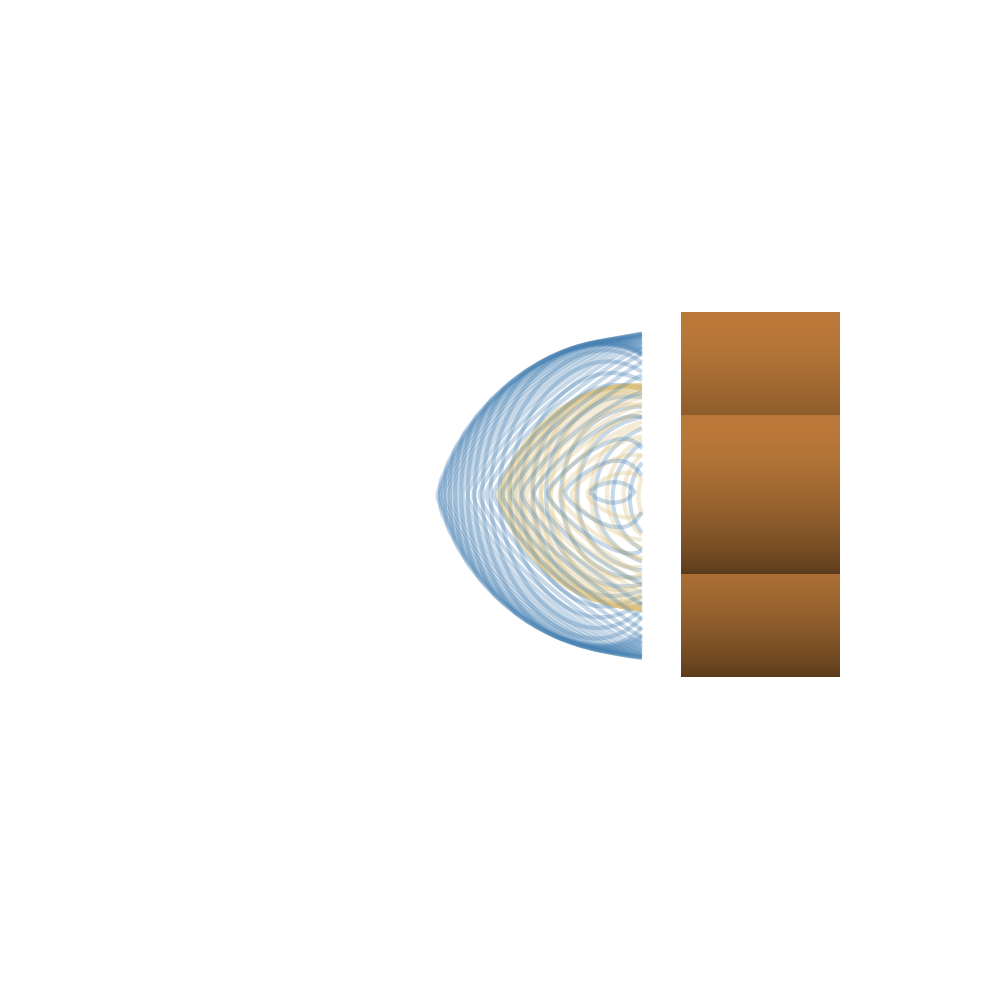

<ipython-input-59-f8846c5aa147>:25: UserWarning: No contour levels were found within the data range.
  ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 18], zdir=zdir, offset=offsetz[i]*100, alpha=0.3, cmap=cmap, linewidths=3, vmin=10, vmax=20)


In [59]:
cmap = cmp_blue_3col

fig = plt.figure(figsize=(10, 10))

plt.style.use('default')
             
ax = plt.axes(projection='3d',proj_type = 'ortho')

ax.view_init(elev= 90, azim = 0)
#ax.view_init(elev= 0, azim = 180)

alpha_min = 0.3
alpha_max = 1.


dcoil = 10
R = 15

# Draw a circle on the x=0 'wall'
coil1 = Circle((0, R), dcoil,facecolor='white',edgecolor='k')
coil2 = Circle((0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')
coil3 = Circle((-0.87*R, -0.5*R), dcoil,facecolor='white',edgecolor='k')

for i in range(Nxy):
    ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [10, 18], zdir=zdir, offset=offsetz[i]*100, alpha=0.3, cmap=cmap, linewidths=3, vmin=10, vmax=20)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [20], zdir=zdir, offset=offsetz[i]*100, alpha=0.5, cmap=cmap,linewidths=3, vmin=0, vmax=65)
    #ax.contour(px_xy*100, py_xy*100, max_field_xy[i]*1000, [30], zdir=zdir, offset=offsetz[i]*100, alpha=0.7, cmap=cmap,linewidths=3, vmin=0, vmax=65)
#for i in range(Nxz):
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10, 18], zdir=ydir, offset=offsety[i]*100, alpha=0.5, colors='black', linewidths=3, linestyles='solid')
    #ax.contour(py_xz*100, max_field_xz[i]*1000, px_xz*100, [10,20,30], zdir=ydir, offset=offsety[i]*100, alpha=0.3, colors='white',linestyles='solid')

#ax.add_patch(coil1)
#art3d.pathpatch_2d_to_3d(coil1, z=20, zdir="y")
#ax.add_patch(coil2)
#art3d.pathpatch_2d_to_3d(coil2, z=20, zdir="y")
#ax.add_patch(coil3)
#art3d.pathpatch_2d_to_3d(coil3, z=20, zdir="y")

coil_length = 20
offset_y = 20

center1 = [0,offset_y+coil_length/2,R]
center2 = [0.87*R,offset_y+coil_length/2,-0.5*R]
center3 = [-0.87*R,offset_y+coil_length/2,-0.5*R]


direction = [0,1,0]
PlotCoils3D_coord(coil_length,dcoil,center1,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center2,direction,ax,True)
PlotCoils3D_coord(coil_length,dcoil,center3,direction,ax,True)
   
#Arg for linestyle: linestyles{None, 'solid', 'dashed', 'dashdot', 'dotted'}

#Ref points
#ax.scatter(0,20,0)
#ax.scatter(0,20,-10)

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim(-30,30)
ax.set_ylim(-20,20)
ax.set_zlim(-30,30)
ax.set_aspect('equal')
#ax.set_title('Maximum field magnitude [mT] for 50 A')

#ax.set_facecolor("grey")
plt.grid(False)
plt.axis('off')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))
plt.show()
